In [10]:
!pip install medmnist
!pip install torch

In [11]:
!pip install torchmetrics

In [19]:
import medmnist
from medmnist import INFO
import torch
from torchvision import transforms
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [14]:
# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [15]:
# check data properties
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}")
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.7255, 0.7176, 0.7333],
         [0.7098, 0.7255, 0.7176,  ..., 0.5451, 0.5059, 0.4902],
         [0.7255, 0.7255, 0.7176,  ..., 0.6314, 0.6235, 0.6392],
         ...,
         [0.7098, 0.7020, 0.7333,  ..., 0.7333, 0.7255, 0.7333],
         [0.6706, 0.7020, 0.7333,  ..., 0.7333, 0.7333, 0.7333],
         [0.6863, 0.7255, 0.7333,  ..., 0.7255, 0.7333, 0.7412]],

        [[0.6314, 0.6235, 0.6235,  ..., 0.6314, 0.6235, 0.6314],
         [0.6157, 0.6235, 0.6157,  ..., 0.3882, 0.3490, 0.3176],
         [0.6314, 0.6235, 0.6078,  ..., 0.4980, 0.5059, 0.5216],
         ...,
         [0.6078, 0.5765, 0.6314,  ..., 0.6314, 0.6314, 0.6392],
         [0.5059, 0.5686, 0.6314,  ..., 0.6314, 0.6392, 0.6314],
         [0.5294, 0.6235, 0.6314,  ..., 0.6314, 0.6314, 0.6392]],

        [[0.7804, 0.7804, 0.7804,  ..., 0.7804, 0.7804, 0.7804],
         [0.7725, 0.7725, 0.7725,  ..., 0.5843, 0.5451, 0.5294],
         [0.7725, 0.7725, 0.7647,  ..., 0.6706, 0.

In [16]:
# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

number of channels: 3
number of classes: 9
class names: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


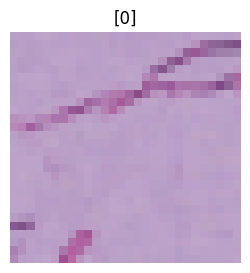

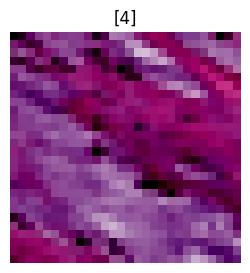

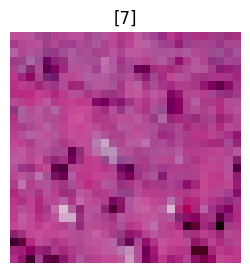

In [17]:
for i in range(3):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False);

In [18]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from skimage.exposure import equalize_hist
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

# Preprocess: Flatten and normalize the images
def preprocess_images(data):
    x_data = []
    for img, label in data:
        img = img.numpy().flatten()  # Flatten and convert to numpy array
        x_data.append(img)
    return np.array(x_data)

# Preprocess the training and test data
x_train = preprocess_images(train_data)
y_train = np.array([label for _, label in train_data])
x_test = preprocess_images(test_data)
y_test = np.array([label for _, label in test_data])

# Ensure y_train and y_test are 1D arrays
y_train = y_train.ravel()  # Flatten the target to 1D array
y_test = y_test.ravel()    # Flatten the target to 1D array

x_train = x_train / 255.0
x_test = x_test / 255.0

# Feature Engineering: Add additional statistical features (mean, variance)
means_train = np.mean(x_train, axis=1)
variances_train = np.var(x_train, axis=1)
x_train_with_stats = np.column_stack((x_train, means_train, variances_train))

means_test = np.mean(x_test, axis=1)
variances_test = np.var(x_test, axis=1)
x_test_with_stats = np.column_stack((x_test, means_test, variances_test))

# Feature Selection: Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Reduce to 100 components (tune this value as needed)
x_train_pca = pca.fit_transform(x_train_with_stats)
x_test_pca = pca.transform(x_test_with_stats)

# Feature Selection: Select top 50 features using SelectKBest with ANOVA F-test (f_classif)
selector = SelectKBest(f_classif, k=50)
x_train_selected = selector.fit_transform(x_train_pca, y_train)
x_test_selected = selector.transform(x_test_pca)

Best Parameters Found: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Score: 0.6519511688920988
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1338
           1       0.73      0.98      0.84       847
           2       0.36      0.71      0.48       339
           3       0.50      0.34      0.40       634
           4       0.86      0.53      0.65      1035
           5       0.33      0.34      0.33       592
           6       0.41      0.35      0.38       741
           7       0.41      0.37      0.39       421
           8       0.54      0.61      0.57      1233

    accuracy                           0.59      7180
   macro avg       0.55      0.56      0.54      7180
weighted avg       0.61      0.59      0.59      7180



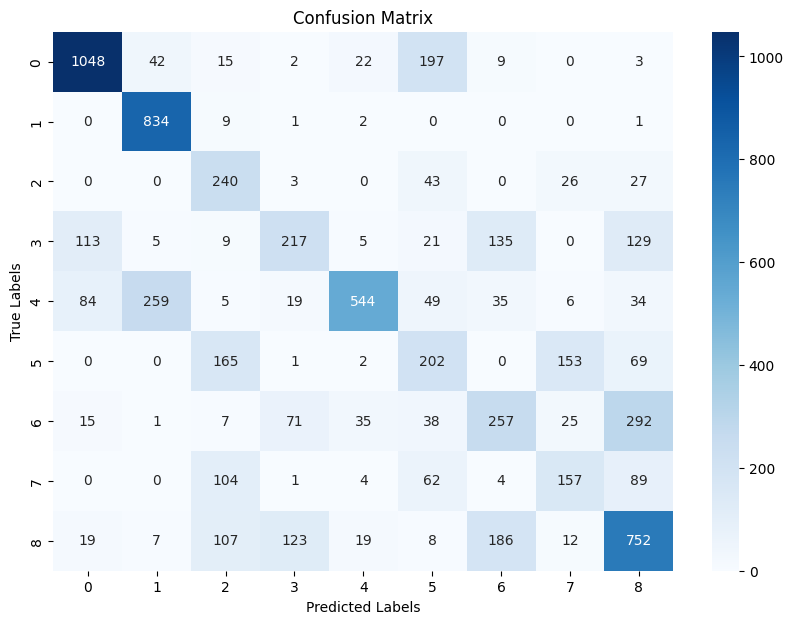

['best_decision_tree_model.pkl']

In [24]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_selected, y_train)

# Output the best parameters and best score from cross-validation
print("Best Parameters Found:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Use the best estimator for predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_selected)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=info['label'], yticklabels=info['label'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optionally, save the best model to disk
joblib.dump(best_model, 'best_decision_tree_model.pkl')

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1338
           1       0.73      0.98      0.84       847
           2       0.36      0.71      0.48       339
           3       0.50      0.34      0.40       634
           4       0.86      0.53      0.65      1035
           5       0.33      0.34      0.33       592
           6       0.41      0.35      0.38       741
           7       0.41      0.37      0.39       421
           8       0.54      0.61      0.57      1233

    accuracy                           0.59      7180
   macro avg       0.55      0.56      0.54      7180
weighted avg       0.61      0.59      0.59      7180



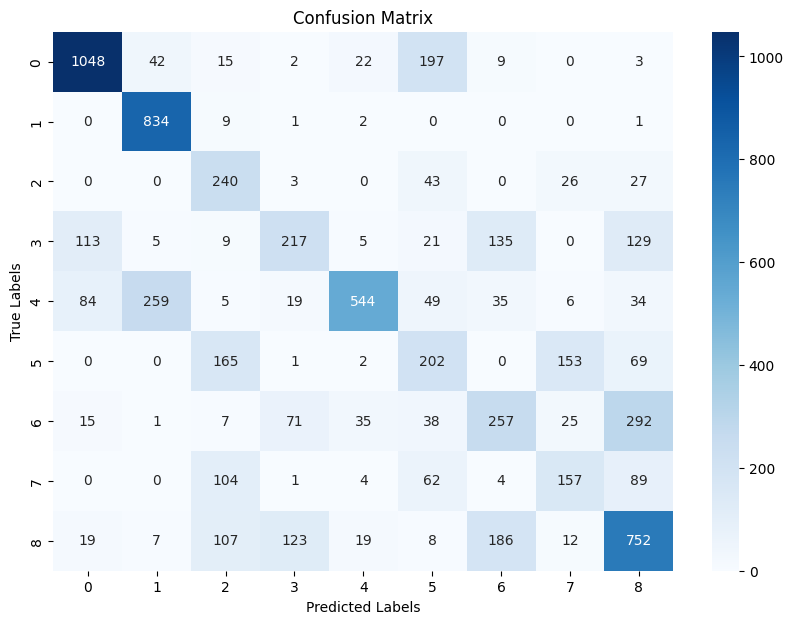

In [25]:
best_model = joblib.load('best_decision_tree_model.pkl')

# Make predictions using the best model
y_pred = best_model.predict(x_test_selected)

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate predictions on the test set using the trained model
y_pred = best_model.predict(x_test_selected)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'], yticklabels=info['label'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()